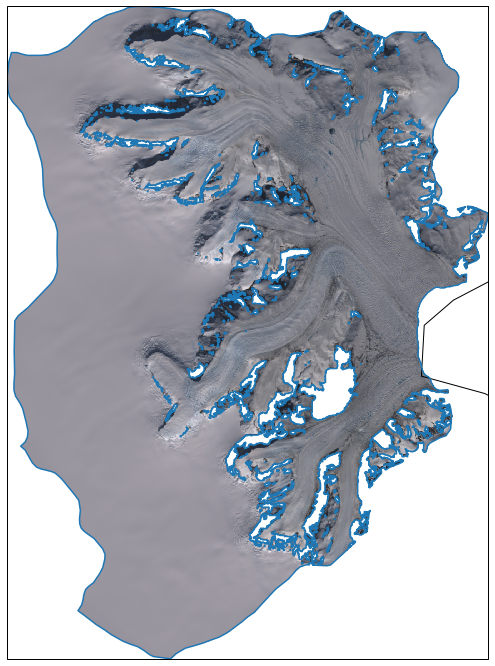

In [6]:
from pathlib import Path
import numpy as np
import cartopy.crs as ccrs
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import rasterio.mask


fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

DATA_DIR = Path('./data')
LANDSAT_FILENAMES = [
    'LC08_L1GT_217105_20171203_20171207_01_T2_B4.TIF',
    'LC08_L1GT_217105_20171203_20171207_01_T2_B3.TIF',
    'LC08_L1GT_217105_20171203_20171207_01_T2_B2.TIF',
]
ROI_SHAPEFILE = 'shapefiles/edgeworth_polygons.kml'

# define cartopy crs for the raster
src_crs = ccrs.SouthPolarStereo(true_scale_latitude=-71)

# load roi shapefile for plotting and clipping image
gdf = gpd.read_file(ROI_SHAPEFILE).to_crs(src_crs.proj4_init)

rgb = []
for filename in LANDSAT_FILENAMES:
    with rasterio.open(DATA_DIR / filename, 'r') as src:
        # crop to our ROI
        im, transform = rasterio.mask.mask(src, gdf.geometry, crop=True)

        # move first axis to last
        im = np.moveaxis(im, 0, -1)

        # Set 0 values (no data) to nan
        im = im.astype(float)
        im[im == 0] = np.nan

        rgb.append(im)

# merge bands
rgb = np.dstack(rgb)
height, width, _ = rgb.shape

# mask zero values (no data)
mask = np.isnan(rgb)
rgb = np.ma.masked_where(mask, rgb)

# normalize
rgb = rgb / rgb.max()

# use mask as transparency array
flat_mask = np.logical_not(np.expand_dims(mask.any(axis=-1), axis=-1))
rgba = np.dstack([rgb, flat_mask])

# calculate extent of raster
xmin = transform[2]
xmax = transform[2] + transform[0] * width
ymin = transform[5] + transform[4] * height
ymax = transform[5]

# create figure
fig = plt.figure(figsize=(18, 12))
ax = plt.axes(projection=src_crs)

# plot raster
ax.imshow(
    rgba,
    origin='upper',
    extent=[xmin, xmax, ymin, ymax],
    transform=src_crs,
    interpolation='nearest',
)

# plot coastlines
ax.coastlines(resolution='10m')

xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
gdf.boundary.plot(ax=ax, color=None);